# CNN Classifier Training Example

This notebook demonstrates a basic 4-layer CNN trained to classify spectra from galaxies and galaxies + SNe Ia within 2 weeks (plus/minus) of max light.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

Adding more spectral categories is straightforward.

In [2]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

## Input Spectra

Input DESI spectra, rebin and rescale them, and then divide them into training and test sets for the classifier.

In [1]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [27]:
snia_truth = np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/sneia*/*truth.fits')))
snia_coadd = np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/sneia*/*coadd.fits')))
snia_flux  = condition_spectra(host_coadd, host_truth)

In [28]:
host_truth = np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/host*/*truth.fits')))
host_files= np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/host*/*coadd.fits')))
host_flux  = condition_spectra(snia_files, snia_truth)

In [29]:
nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

(9969, 9964, 150)

### Plot Spectra to Check Output

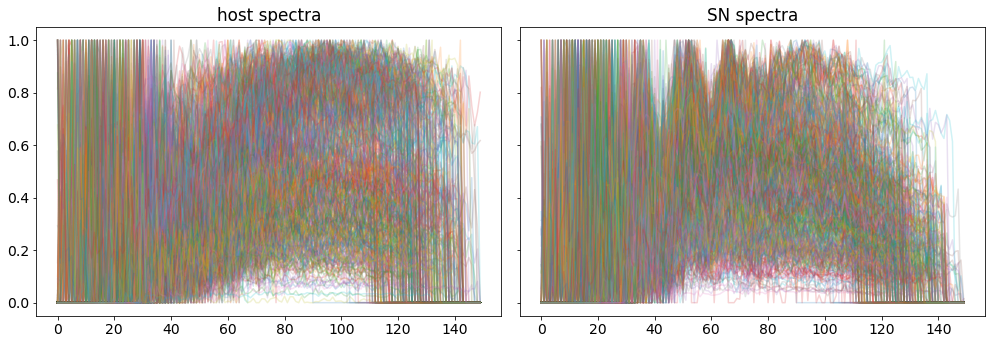

In [31]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('SN spectra')

fig.tight_layout()

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
1. "snia" spectra based on BGS + SN Ia templates

In [32]:
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

## CNN Network Setup

Train network with TensorFlow+Keras.

In [33]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [34]:
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
    
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [35]:
model = network((nbins, 1))

## Train and Test

Split the data into training and testing (validation) samples and fit the network weights.

In [36]:
permute = np.random.permutation(len(y))
l = len(x)
hist = model.fit(x[permute][:l], y[permute][:l], batch_size=64, epochs=50, validation_split=0.25, shuffle=True)

Train on 14949 samples, validate on 4984 samples
Epoch 1/50
14949/14949 [==============================] - 11s 723us/step - loss: 1.5714 - acc: 0.7304 - val_loss: 1.4110 - val_acc: 0.6463
Epoch 2/50
14949/14949 [==============================] - 9s 617us/step - loss: 0.9905 - acc: 0.8500 - val_loss: 0.8586 - val_acc: 0.8720
Epoch 3/50
14949/14949 [==============================] - 9s 606us/step - loss: 0.7246 - acc: 0.8854 - val_loss: 0.6534 - val_acc: 0.8898
Epoch 4/50
14949/14949 [==============================] - 9s 608us/step - loss: 0.5736 - acc: 0.9072 - val_loss: 0.5375 - val_acc: 0.8969
Epoch 5/50
14949/14949 [==============================] - 9s 610us/step - loss: 0.4741 - acc: 0.9158 - val_loss: 0.4589 - val_acc: 0.9019
Epoch 6/50
14949/14949 [==============================] - 10s 646us/step - loss: 0.4057 - acc: 0.9237 - val_loss: 0.4705 - val_acc: 0.8852
Epoch 7/50
14949/14949 [==============================] - 9s 629us/step - loss: 0.3613 - acc: 0.9286 - val_loss: 0.3717 -

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

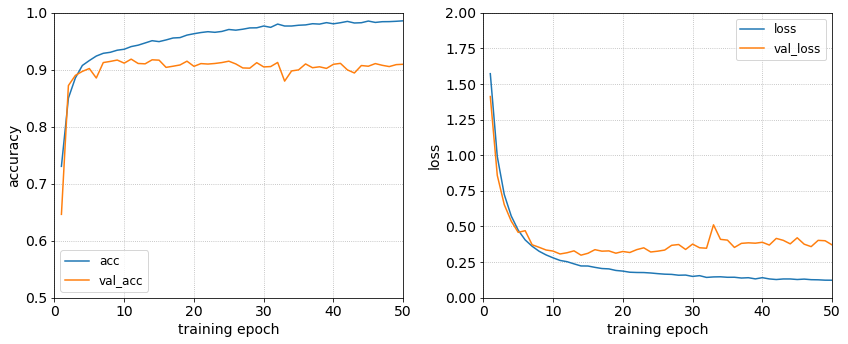

In [37]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

### ROC Curve and Precision-Recall

In [38]:
idx = np.random.choice(a=len(y), size=int(0.2 * len(y)))
x_test = x[idx]
y_test = y[idx]
y_pred = model.predict(x_test).ravel()

In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
pre, rec, _ = precision_recall_curve(y_test, y_pred)

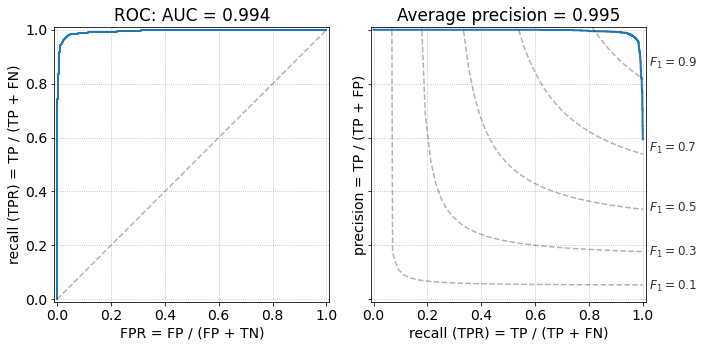

In [40]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

### Confusion Matrix

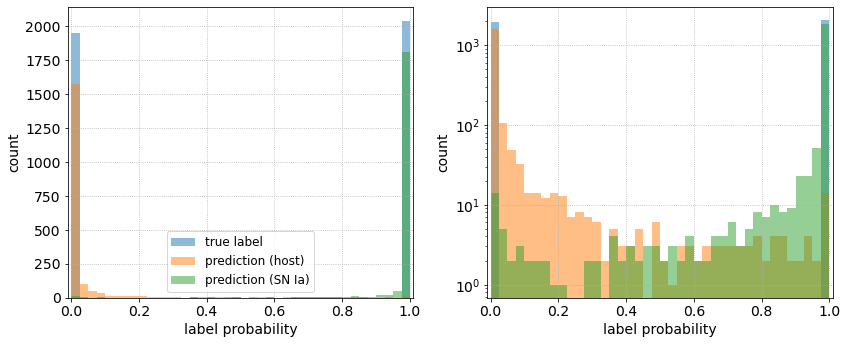

In [41]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax = axes[0]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)')
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')
ax.legend(fontsize=12, loc='best')

ax = axes[1]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)', log=True)
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')

fig.tight_layout()

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

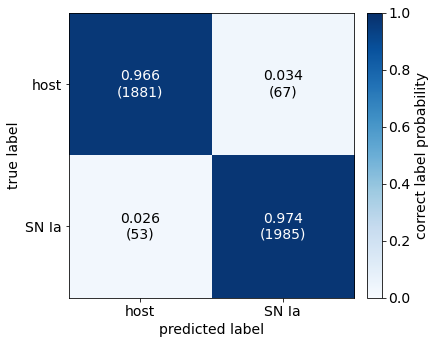

In [43]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

In [44]:
model.save('twolabel_cnn')

In [45]:
model.save('twolabel_cnn.h5')

# Trying what we have been doing

In [46]:
# Splitting
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.25)

Epoch 1/50
14949/14949 [==============================] - 10s 674us/step - loss: 1.5474 - acc: 0.7428
Epoch 2/50
14949/14949 [==============================] - 9s 571us/step - loss: 0.9717 - acc: 0.8595
Epoch 3/50
14949/14949 [==============================] - 8s 562us/step - loss: 0.7137 - acc: 0.8901
Epoch 4/50
14949/14949 [==============================] - 8s 563us/step - loss: 0.5688 - acc: 0.9051
Epoch 5/50
14949/14949 [==============================] - 8s 562us/step - loss: 0.4718 - acc: 0.9137
Epoch 6/50
14949/14949 [==============================] - 8s 561us/step - loss: 0.4105 - acc: 0.9157
Epoch 7/50
14949/14949 [==============================] - 8s 563us/step - loss: 0.3615 - acc: 0.9233
Epoch 8/50
14949/14949 [==============================] - 9s 588us/step - loss: 0.3295 - acc: 0.9249
Epoch 9/50
14949/14949 [==============================] - 9s 607us/step - loss: 0.3009 - acc: 0.9314
Epoch 10/50
14949/14949 [==============================] - 8s 557us/step - loss: 0.2796 - 

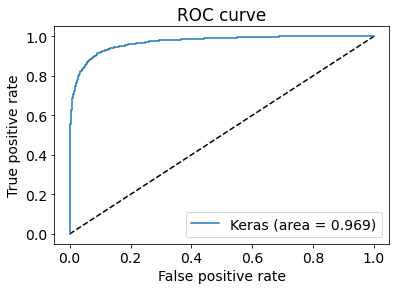

In [47]:
"""Trying from the blog"""
# Classifier
keras_model = network((nbins, 1))
keras_model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=1)
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

# Area under the curve
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Average precision-recall score: 0.97


Text(0.5, 1.0, 'Precision Recall Curve with average precision of 0.97')

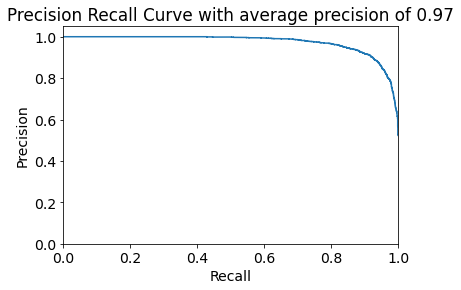

In [48]:
############
import random
import pylab as pl
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

"""# The source code uses decision_function
but that is only applicable to sequential class and not the model class that our classifer uses.
Check here for more reference: https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun"""
y_score = keras_model.predict(x_test).ravel() 


# Average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

#https://scikit-plot.readthedocs.io/en/stable/Quickstart.html
#Used Professor's Benzvi's code for PR curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_keras)
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve with average precision of {0:0.2f}'.format(average_precision))

########

Normalized confusion matrix
Accuracy:  0.8912520064205457


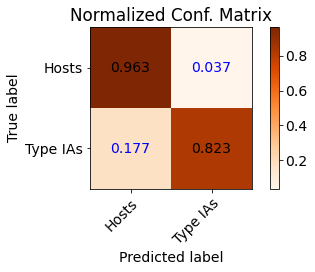

In [49]:
from sklearn.metrics import confusion_matrix

y_pred = y_pred_keras

def plotConfusionMatrix(y_true, y_pred, classes=["Hosts", "Type IAs", "Type IIPs"], cmap=plt.cm.Oranges, title="Normalized Confusion Matrix"):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred > 0.5)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    #print(cm)
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # create text annotations
    fmt = '.3f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="blue" if cm[i, j] < thresh else "black")
    fig.tight_layout()
    plt.ylim([1.5, -.5])

    plt.show()
    return ax

for i in range(len(y_pred)):
    y_pred[i]=round(y_pred[i])

plotConfusionMatrix(y_true=y_test, y_pred=y_pred, title="Normalized Conf. Matrix")